In [262]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE

from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.inspection import permutation_importance

import sklearn
sklearn.set_config(display = 'diagram') 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
survey = pd.read_csv('data/train.csv')

In [4]:
survey.head(3)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
2,fffe31003300320037003900,2008-03-10,Female,Product,Yes,2.0,NaN,5.8,0.49


In [6]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Employee ID           22750 non-null  object 
 1   Date of Joining       22750 non-null  object 
 2   Gender                22750 non-null  object 
 3   Company Type          22750 non-null  object 
 4   WFH Setup Available   22750 non-null  object 
 5   Designation           22750 non-null  float64
 6   Resource Allocation   21369 non-null  float64
 7   Mental Fatigue Score  20633 non-null  float64
 8   Burn Rate             21626 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.6+ MB


## EDA

In [9]:
# change 'Date of Joining' to datetime datatype

survey['Date of Joining'] = pd.to_datetime(survey['Date of Joining'])

In [10]:
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22750 entries, 0 to 22749
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Employee ID           22750 non-null  object        
 1   Date of Joining       22750 non-null  datetime64[ns]
 2   Gender                22750 non-null  object        
 3   Company Type          22750 non-null  object        
 4   WFH Setup Available   22750 non-null  object        
 5   Designation           22750 non-null  float64       
 6   Resource Allocation   21369 non-null  float64       
 7   Mental Fatigue Score  20633 non-null  float64       
 8   Burn Rate             21626 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 1.6+ MB


In [14]:
survey.isna().sum()

Employee ID                0
Date of Joining            0
Gender                     0
Company Type               0
WFH Setup Available        0
Designation                0
Resource Allocation     1381
Mental Fatigue Score    2117
Burn Rate               1124
dtype: int64

In [26]:
# impute null values

survey['Resource Allocation'].fillna(1.0, inplace = True)
survey['Mental Fatigue Score'].fillna(0.0, inplace = True)
survey['Burn Rate'].fillna(0.0, inplace = True)

In [27]:
# ensure null values are imputed

survey.isna().sum()

Employee ID             0
Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
Burn Rate               0
dtype: int64

In [48]:
# create copy of dataset

burnout = survey.copy()

In [49]:
burnout.head(3)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20


In [69]:
# compute # of days employee worked

burnout['Days Worked'] = (pd.to_datetime('2020-03-01') - burnout['Date of Joining']).dt.days

In [71]:
burnout.head(3)

,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Days Worked
0,fffe32003000360033003200,2008-09-30,Female,Service,No,2.0,3.0,3.8,0.16,4170
1,fffe3700360033003500,2008-11-30,Male,Service,Yes,1.0,2.0,5.0,0.36,4109
3,fffe32003400380032003900,2008-11-03,Male,Service,Yes,1.0,1.0,2.6,0.20,4136


In [47]:
burnout['Date of Joining'].dt.year.value_counts()

2008    18590
Name: Date of Joining, dtype: int64

In [42]:
burnout['Company Type'].value_counts()

Service    12174
Product     6416
Name: Company Type, dtype: int64

In [88]:
burnout['Gender'].value_counts()

Female    9747
Male      8843
Name: Gender, dtype: int64

## Data Visualizations

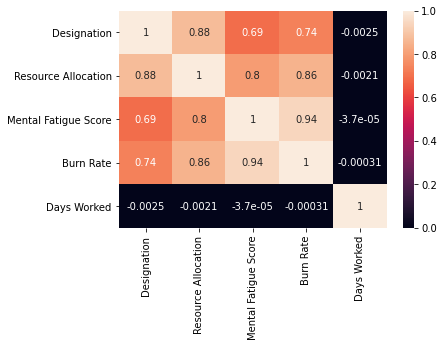

In [166]:
sns.heatmap(burnout.corr(), annot = True);

In [168]:
burnout.corr()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Days Worked
Designation,1.000000,0.877893,0.691823,0.736412,-0.002507
Resource Allocation,0.877893,1.000000,0.799563,0.855005,-0.002069
Mental Fatigue Score,0.691823,0.799563,1.000000,0.944389,-0.000037
Burn Rate,0.736412,0.855005,0.944389,1.000000,-0.000309
Days Worked,-0.002507,-0.002069,-0.000037,-0.000309,1.000000


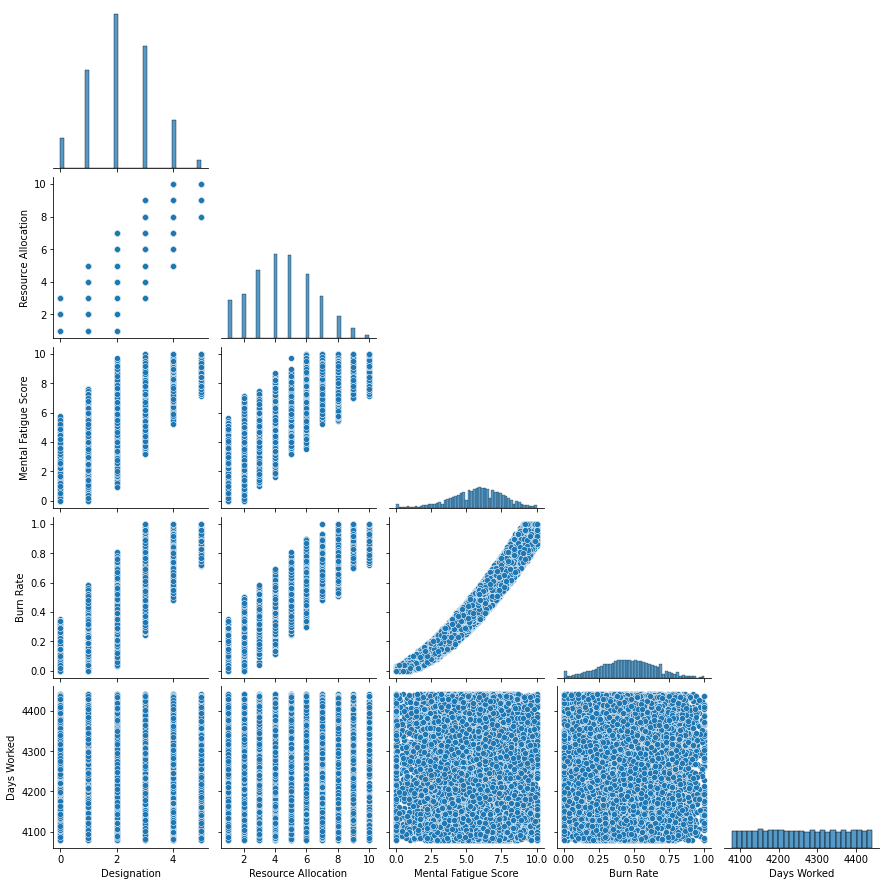

In [169]:
sns.pairplot(burnout, corner = True);

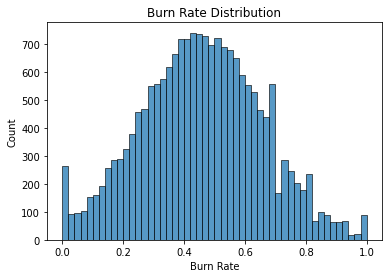

In [76]:
# relatively normally distributed

sns.histplot(burnout['Burn Rate'])
plt.title('Burn Rate Distribution');

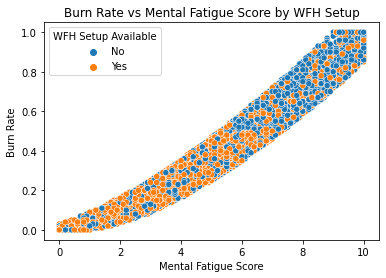

In [81]:
sns.scatterplot(x = 'Mental Fatigue Score', y = 'Burn Rate', data = burnout, hue = 'WFH Setup Available')
plt.title('Burn Rate vs Mental Fatigue Score by WFH Setup');

In [182]:
burnout.groupby('Gender').mean()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate,Days Worked
Gender,,,,,
Female,2.060121,4.211757,5.465538,0.422938,4260.579871
Male,2.310867,4.789438,6.026066,0.484967,4260.435260


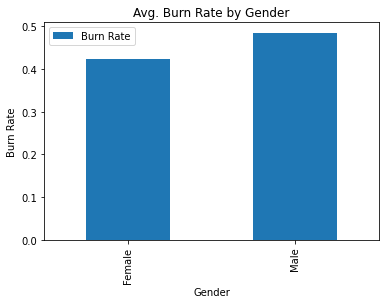

In [186]:
burnout.groupby('Gender').mean()[['Burn Rate']].plot(kind = 'bar')
plt.title('Avg. Burn Rate by Gender')
plt.ylabel('Burn Rate');

In [184]:
burnout.groupby('Designation').mean()

,Resource Allocation,Mental Fatigue Score,Burn Rate,Days Worked
Designation,,,,
0.0,1.205170,2.637157,0.151325,4257.977383
1.0,2.587759,4.443171,0.308475,4262.167678
2.0,4.187963,5.672385,0.436468,4260.228516
3.0,5.738618,6.623577,0.545242,4261.228659
4.0,7.453005,7.735645,0.687001,4257.044171
5.0,9.186120,8.929022,0.856467,4265.438486


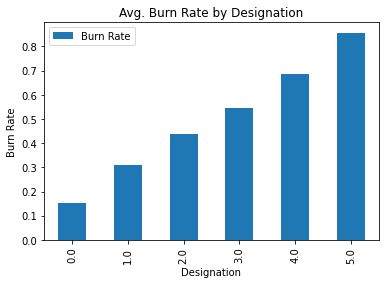

In [189]:
burnout.groupby('Designation').mean()[['Burn Rate']].plot(kind = 'bar')
plt.title('Avg. Burn Rate by Designation')
plt.ylabel('Burn Rate');

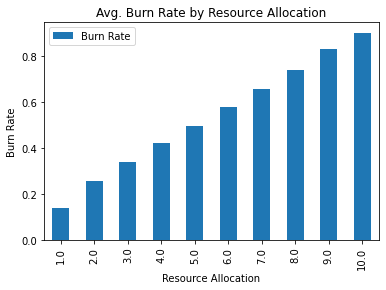

In [190]:
burnout.groupby('Resource Allocation').mean()[['Burn Rate']].plot(kind = 'bar')
plt.title('Avg. Burn Rate by Resource Allocation')
plt.ylabel('Burn Rate');

## Modeling

In [98]:
# establish X + y

X = burnout.drop(columns = ['Burn Rate', 'Employee ID', 'Date of Joining'])
y = burnout['Burn Rate']

### Baseline Null Model

In [102]:
mean_y_array = np.full_like(y, y.mean())

# RMSE
print(f'Baseline RMSE: {mean_squared_error(y, mean_y_array, squared = False)}')

Baseline RMSE: 0.1978422508120104


In [104]:
# tts

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [105]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13942, 7)
(13942,)
(4648, 7)
(4648,)


### Linear Regression

In [116]:
# make pipe
pipe_lr = make_pipeline(OneHotEncoder(use_cat_names = True), StandardScaler(), LinearRegression())

# fit
pipe_lr.fit(X_train, y_train)

# score
print(f'Train Score: {pipe_lr.score(X_train, y_train)}')
print(f'Test Score: {pipe_lr.score(X_test, y_test)}')

Train Score: 0.9199560564553836
Test Score: 0.9226200902036071


In [152]:
# predictions
preds_lr = pipe_lr.predict(X_test)

# RMSE
rmse_lr = mean_squared_error(y_test, preds, squared = False)
print(f'RMSE: {rmse_lr}')

RMSE: 0.05590178728801217


### Lasso

In [112]:
# make pipe
pipe_lasso = make_pipeline(OneHotEncoder(use_cat_names = True), StandardScaler(), Lasso(max_iter = 10000, random_state = 123))

# params
params = {'lasso__alpha' : [.01, 1, 5, 10, 100]}

# GridSearchCV
gs_lasso = GridSearchCV(pipe_lasso, params, n_jobs = -1)

# fit
gs_lasso.fit(X_train, y_train)

# best params
print(gs_lasso.best_params_)

# score
print(f'Train Score: {gs_lasso.score(X_train, y_train)}')
print(f'Test Score: {gs_lasso.score(X_test, y_test)}')

{'lasso__alpha': 0.01}
Train Score: 0.9159434902437498
Test Score: 0.9187179724452607


In [153]:
# predictions
preds_lasso = gs_lasso.predict(X_test)

# RMSE
rmse_lasso = mean_squared_error(y_test, preds_lasso, squared = False)
print(f'RMSE: {rmse_lasso}')

RMSE: 0.05729337085706847


### Ridge

In [120]:
# make pipe
pipe_ridge = make_pipeline(OneHotEncoder(use_cat_names = True), StandardScaler(), Ridge(max_iter = 1000, random_state = 123))

# establish parameters
params = {'ridge__alpha' : [.01, .1, 1, 10, 100]}

# instantiate GridSearchCV
gs_ridge = GridSearchCV(pipe_ridge, params, n_jobs = -1)

# fit on Train data
gs_ridge.fit(X_train, y_train)

# best params
print(gs_ridge.best_params_)

# score
print(f'Train Score: {gs_ridge.score(X_train, y_train)}')
print(f'Test Score: {gs_ridge.score(X_test, y_test)}')

{'ridge__alpha': 1}
Train Score: 0.9199685136851933
Test Score: 0.9226447361345962


In [154]:
# predictions
preds_ridge = gs_ridge.predict(X_test)

# RMSE
rmse_ridge = mean_squared_error(y_test, preds_ridge, squared = False)
print(f'RMSE: {rmse_ridge}')

RMSE: 0.05589230836695595


In [132]:
# refining Ridge

# make pipe
pipe_ridge2 = make_pipeline(OneHotEncoder(use_cat_names = True), StandardScaler(), PolynomialFeatures(), RFE(Ridge()), Ridge(max_iter = 1000, random_state = 123))

# establish parameters
params = {'ridge__alpha' : [.01, .1, 1, 10, 100]}

# instantiate GridSearchCV
gs_ridge2 = GridSearchCV(pipe_ridge2, params, n_jobs = -1)

# fit on Train data
gs_ridge2.fit(X_train, y_train)

# best params
print(gs_ridge2.best_params_)

# score
print(f'Train Score: {gs_ridge2.score(X_train, y_train)}')
print(f'Test Score: {gs_ridge2.score(X_test, y_test)}')

{'ridge__alpha': 1}
Train Score: 0.9237332886963721
Test Score: 0.9270112124444666


In [155]:
# predictions
preds_ridge2 = gs_ridge2.predict(X_test)

# RMSE
rmse_ridge2 = mean_squared_error(y_test, preds_ridge2, squared = False)
print(f'RMSE: {rmse_ridge2}')

RMSE: 0.054291918097330805


### KNeighborsRegressor

In [135]:
# make pipe
pipe_knn = make_pipeline(OneHotEncoder(use_cat_names = True), StandardScaler(), KNeighborsRegressor(n_jobs = -1))

# establish parameters
params = {'kneighborsregressor__n_neighbors' : [7, 9, 11, 13, 15]}

# instantiate GridSearchCV
gs_knn = GridSearchCV(pipe_knn, params, n_jobs = -1)

# fit on Train data
gs_knn.fit(X_train, y_train)

# best params
print(gs_knn.best_params_)

# score
print(f'Train Score: {gs_knn.score(X_train, y_train)}')
print(f'Test Score: {gs_knn.score(X_test, y_test)}')

{'kneighborsregressor__n_neighbors': 11}
Train Score: 0.9265062446748882
Test Score: 0.913875815963086


In [156]:
# predictions
preds_knn = gs_ridge.predict(X_test)

# RMSE
rmse_knn = mean_squared_error(y_test, preds_knn, squared = False)
print(f'RMSE: {rmse_knn}')

RMSE: 0.05589230836695595


### Hist Gradient Booster -- BEST MODEL

In [149]:
# make pipe
pipe_hboost = make_pipeline(OneHotEncoder(use_cat_names = True), StandardScaler(), HistGradientBoostingRegressor(max_iter = 1000, random_state = 123))

# establish parameters
params = {'histgradientboostingregressor__max_depth' : [4, 5, 6, 7],
          'histgradientboostingregressor__learning_rate' : [0.01, 0.1, 0.5, 1]}

# instantiate GridSearchCV
gs_hboost = GridSearchCV(pipe_hboost, params, n_jobs = -1)

# fit on Train data
gs_hboost.fit(X_train, y_train)

# best params
print(gs_hboost.best_params_)

# score
print(f'Train Score: {gs_hboost.score(X_train, y_train)}')
print(f'Test Score: {gs_hboost.score(X_test, y_test)}')

{'histgradientboostingregressor__learning_rate': 0.1, 'histgradientboostingregressor__max_depth': 7}
Train Score: 0.9326646154061559
Test Score: 0.9305279497701231


In [157]:
# predictions
preds_hboost = gs_hboost.predict(X_test)

# RMSE
rmse_hboost = mean_squared_error(y_test, preds_hboost, squared = False)
print(f'RMSE: {rmse_hboost}')

RMSE: 0.05296782846351151


### Ada Booster

In [144]:
# make pipe
pipe_ada = make_pipeline(OneHotEncoder(use_cat_names = True), StandardScaler(), AdaBoostRegressor(random_state = 123))

# establish parameters
params = {'adaboostregressor__n_estimators' : [10, 15, 25, 30],
          'adaboostregressor__learning_rate' : [0.01, 0.1, 0.5, 1]}

# instantiate GridSearchCV
gs_ada = GridSearchCV(pipe_ada, params, n_jobs = -1)

# fit on Train data
gs_ada.fit(X_train, y_train)

# best params
print(gs_ada.best_params_)

# score
print(f'Train Score: {gs_ada.score(X_train, y_train)}')
print(f'Test Score: {gs_ada.score(X_test, y_test)}')

{'adaboostregressor__learning_rate': 0.5, 'adaboostregressor__n_estimators': 25}
Train Score: 0.902872158708486
Test Score: 0.9059124035341085


In [158]:
# predictions
preds_ada = gs_ada.predict(X_test)

# RMSE
rmse_ada = mean_squared_error(y_test, preds_ada, squared = False)
print(f'RMSE: {rmse_ada}')

RMSE: 0.06164151409007589


### RandomForestRegressor

In [161]:
# make pipe
pipe_forest = make_pipeline(OneHotEncoder(use_cat_names = True), StandardScaler(), RandomForestRegressor(n_jobs = -1, random_state = 123))

# establish parameters
params = {'randomforestregressor__max_depth' : [4, 5, 6, 7, 8, 9],
          'randomforestregressor__max_features' : [4, 5, 6, 7]}

# instantiate GridSearchCV
gs_forest = GridSearchCV(pipe_forest, params, n_jobs = -1)

# fit on Train data
gs_forest.fit(X_train, y_train)

# best params
print(gs_forest.best_params_)

# score
print(f'Train Score: {gs_forest.score(X_train, y_train)}')
print(f'Test Score: {gs_forest.score(X_test, y_test)}')

{'randomforestregressor__max_depth': 8, 'randomforestregressor__max_features': 6}
Train Score: 0.9335255764820061
Test Score: 0.9302164252409606


In [162]:
# predictions
preds_forest = gs_forest.predict(X_test)

# RMSE
rmse_forest = mean_squared_error(y_test, preds_forest, squared = False)
print(f'RMSE: {rmse_forest}')

RMSE: 0.053086454019046256


-----

## Interpreting Best Model --> Hist Gradient Booster

In [264]:
# REMINDER OF BASELINE

mean_y_array = np.full_like(y, y.mean())

# RMSE
print(f'Baseline RMSE: {mean_squared_error(y, mean_y_array, squared = False)}')
print(f'Hist Gradient Booster RMSE: {rmse_hboost}')

Baseline RMSE: 0.1978422508120104
Hist Gradient Booster RMSE: 0.05296782846351151


**-->** On average, the model was 0.053 units away from the actual Burn Rate. Compared to the Baseline model (0.198), our Linear Regession model performed significantly better (0.053).

In [201]:
# put together a df of the models tested and its RMSEs

estimator = 'linreg', 'ridge','lasso','adaboost', 'knn', 'hboost','randomforest'
rmse = rmse_lr, rmse_ridge, rmse_lasso, rmse_ada, rmse_knn, rmse_hboost, rmse_forest
test_score = pipe_lr.score(X_test, y_test), gs_ridge.score(X_test, y_test), gs_lasso.score(X_test, y_test), gs_ada.score(X_test, y_test), gs_knn.score(X_test, y_test), \
             gs_hboost.score(X_test, y_test), gs_forest.score(X_test, y_test)


all_preds = pd.DataFrame()
all_preds['estimator'] = estimator
all_preds['rmse'] = rmse
all_preds['test_score'] = test_score

In [202]:
all_preds.sort_values(by = 'rmse')

,estimator,rmse,test_score
5,hboost,0.052968,0.930528
6,randomforest,0.053086,0.930216
1,ridge,0.055892,0.922645
4,knn,0.055892,0.913876
0,linreg,0.055902,0.922620
2,lasso,0.057293,0.918718
3,adaboost,0.061642,0.905912


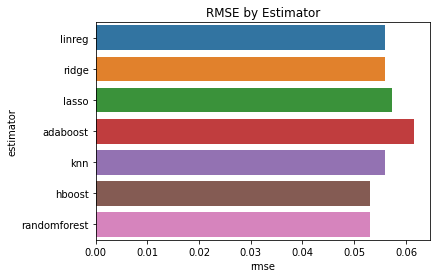

In [195]:
sns.barplot(all_preds['rmse'], all_preds['estimator'])
plt.title('RMSE by Estimator');

**-->** All models produced RMSEs lower than the null baseline, with **Hist Gradient Booster** generating the lowest RMSE. Random Forest Regressor follows closely after. Ada Boost Regeressor produced the highest RMSE, in comparison to the other models tested.

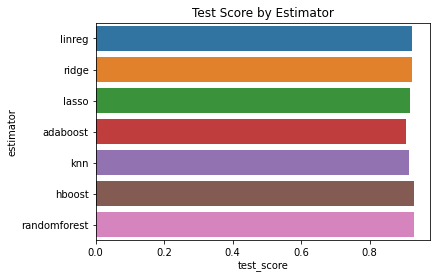

In [203]:
sns.barplot(all_preds['test_score'], all_preds['estimator'])
plt.title('Test Score by Estimator');

**-->** Similarly, all models curated relatively high test scores, however **Hist Gradient Booster** generated the highest test score of the models tested, making it our best model to make predictions. Ada Boost Regressor had the lowest test score.

**--> Model Score:** The Hist Gradient Booster model was able to explain **93.05%** of the variation in the data, based on the features we chose

In [269]:
gs_hboost.best_estimator_

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Gender', 'Company Type',
                                     'WFH Setup Available'],
                               use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(max_depth=7, max_iter=1000,
                                               random_state=123))])

In [225]:
# grab feature importances

hboost_fi_df = pd.DataFrame({'importances': gs_hboost.best_estimator_.named_steps['histgradientboostingregressor'].feature_importances_, 
                             'name': gs_hboost.best_estimator_.named_steps['onehotencoder'].get_feature_names()}).sort_values('importances', ascending = False)
hboost_fi_df[:5]

AttributeError: 'HistGradientBoostingRegressor' object has no attribute 'feature_importances_'

In [224]:
gs_hboost.best_estimator_.named_steps['onehotencoder'].get_feature_names()

['Gender_Male',
 'Gender_Female',
 'Company Type_Service',
 'Company Type_Product',
 'WFH Setup Available_Yes',
 'WFH Setup Available_No',
 'Designation',
 'Resource Allocation',
 'Mental Fatigue Score',
 'Days Worked']

In [220]:
# extract permutation importances
pimports = permutation_importance(gs_hboost.best_estimator_, X_test, y_test, n_repeats = 10, n_jobs = -1)

#sort by averages
sort_idx = pimports.importances_mean.argsort()

#create a Dataframe sorted by importance
imp_df = pd.DataFrame(pimports.importances[sort_idx].T, columns = X_test.columns[sort_idx])

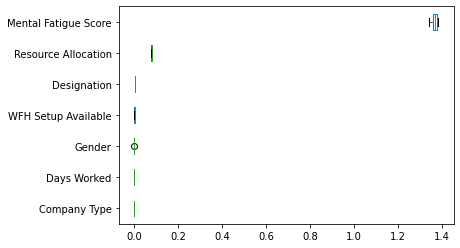

In [259]:
imp_df.plot(kind = 'box', vert = False);

**--> Permutation Feature Importances:**  The generated model changes the order and arrangement of values within each feature n times (n_repeats) and the shuffled feature that changes the score signifcantly will be noted as a more important feature. It doesn't seem like the features have much variation. Lower variation indicates that there is more confidence in the importance of the feature, as the score didn't vary as much based on the 10 iterations that were noted for n_repeats. Additionally, compared to the other features, 'Mental Fatigue Score' is the most imporant feature, as that feature has the highest permutation.

#### LINEM Assumptions

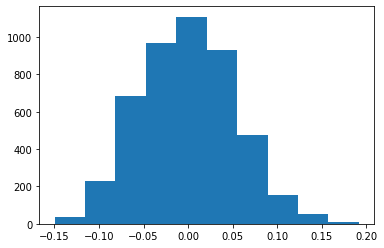

In [227]:
# plotting the distribution of the Hist Gradient Booster residuals
# referenced Lesson 3.04 - Eval Metrics https://git.generalassemb.ly/DSI-322/3.04_Regression_Evaluation/blob/master/eval_metrics.ipynb 

resid_hboost = y_test - preds_hboost
plt.hist(resid_hboost);

**-->** When looking at the distribution of the residuals (our errors), they're normally distributed, which suffices the Normally Distributed errors LINEM assumption.

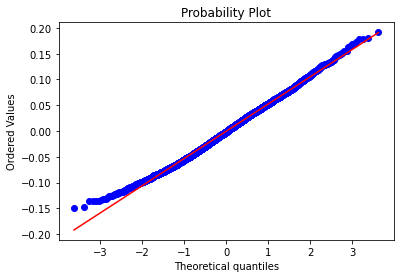

In [263]:
# QQ plot - Comparing residuals to a Theoretical distribution

stats.probplot(resid_hboost, plot = plt);

**-->** Predictions are relatively hugging the line, which means that the residuals (errors) follow a theoretical distribution (normal distribution centered around a mean of 0), further supporting the Normally Distributed errors LINEM assumption